In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes

from sklearn.svm import SVC,LinearSVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report 
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc

from scipy.stats import skew, kurtosis

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#plt.style.use('dark_background')
current_palette = sns.color_palette('colorblind')
sns.palplot(current_palette)

font = {'size'   : 16}
matplotlib.rc('font', **font)

/home/michael/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### import data

In [2]:
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')
about = pd.read_csv('about.csv', sep='\t')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
about

Variable                                      Description
0             Loan_ID                                   Unique Loan ID
1              Gender                                     Male/ Female
2             Married                          Applicant married (Y/N)
3          Dependents                             Number of dependents
4           Education   Applicant Education (Graduate/ Under Graduate)
5       Self_Employed                              Self employed (Y/N)
6     ApplicantIncome                                 Applicant income
7   CoapplicantIncome                               Coapplicant income
8          LoanAmount                         Loan amount in thousands
9    Loan_Amount_Term                           Term of loan in months
10     Credit_History                  credit history meets guidelines
11      Property_Area                         Urban/ Semi Urban/ Rural
12        Loan_Status                              Loan approved (Y/N)

In [4]:
train.LoanAmount = train.LoanAmount*1000

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


In [6]:
train.Loan_Status.value_counts(normalize = True).reset_index()

index  Loan_Status
0     Y     0.687296
1     N     0.312704

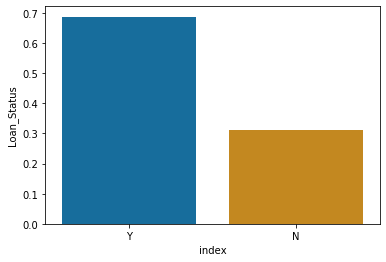

In [7]:
sns.barplot(data = train.Loan_Status.value_counts(normalize = True).reset_index(),
            x = 'index',
            y = 'Loan_Status',
            palette=current_palette)
plt.savefig('Loan_Status_prop.png', format='png')

- we can see the data is not balanced, 69% approved for load while 31% where not
- lets check the proportion in each feature between Y and N

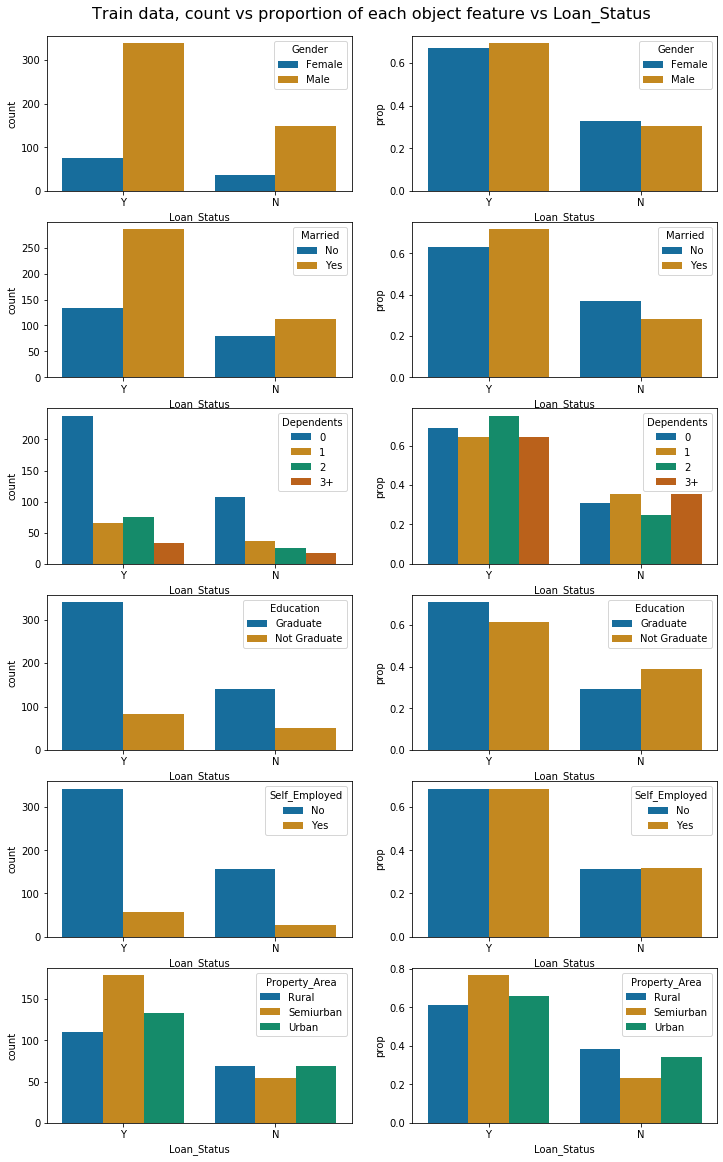

In [8]:
def prop_check(train):
    f, axes = plt.subplots(6,2,figsize= (12,20))
    plt.suptitle('Train data, count vs proportion of each object feature vs Loan_Status', size =16, y = 0.9)
    col = train.columns[1:train.shape[1]-1]
    r = 0
    for i in col:
        if (train_raw.dtypes == 'object')[i]:        
            train_prop = (train['Loan_Status']
                          .groupby(train[i])
                          .value_counts(normalize = True)
                          .rename('prop')
                          .reset_index())
            sns.countplot(data = train, 
                          x ='Loan_Status', 
                          hue = i, 
                          ax = axes[r,0], 
                          hue_order=train_prop[i].unique(), 
                          palette=current_palette)
            sns.barplot(data = train_prop, 
                        x = 'Loan_Status', 
                        y = 'prop',
                        hue = i,
                        ax = axes[r,1],
                        palette=current_palette)
            r = r+1
    
    plt.savefig('prop_vs_count.png', format='png')
prop_check(train)

- as the graphs indicate, they are mostly distributed equaly
- make the Loan_ID column to be an index for further analysis (we could also delete it)

In [9]:
def make_index(df):
    df.set_index('Loan_ID', inplace=True)
    return df
train = make_index(train)
test = make_index(test)

- drop all NAs
- previous attempts to fill the gaps showed that most frequent dummy classifier bring the best results, although increases the bias within the data
- seocnd approach was to use Principal Component Analisys, which didn't improve much the models outputs (around 80% accuracy) and we found it dificult to point the main features contributing to the predictions results
- other approach we have tried is reduce the bias by duplicating the Y and N data to recieve 3 balance "train" groups, with the same N groups at the 3 of them. this approach gave some improvement (1%-2%) at the LogisticRegression and NaiveBayes models but overfitted the  RandomForest

In [10]:
train.dropna(inplace=True)
test.dropna(inplace=True)

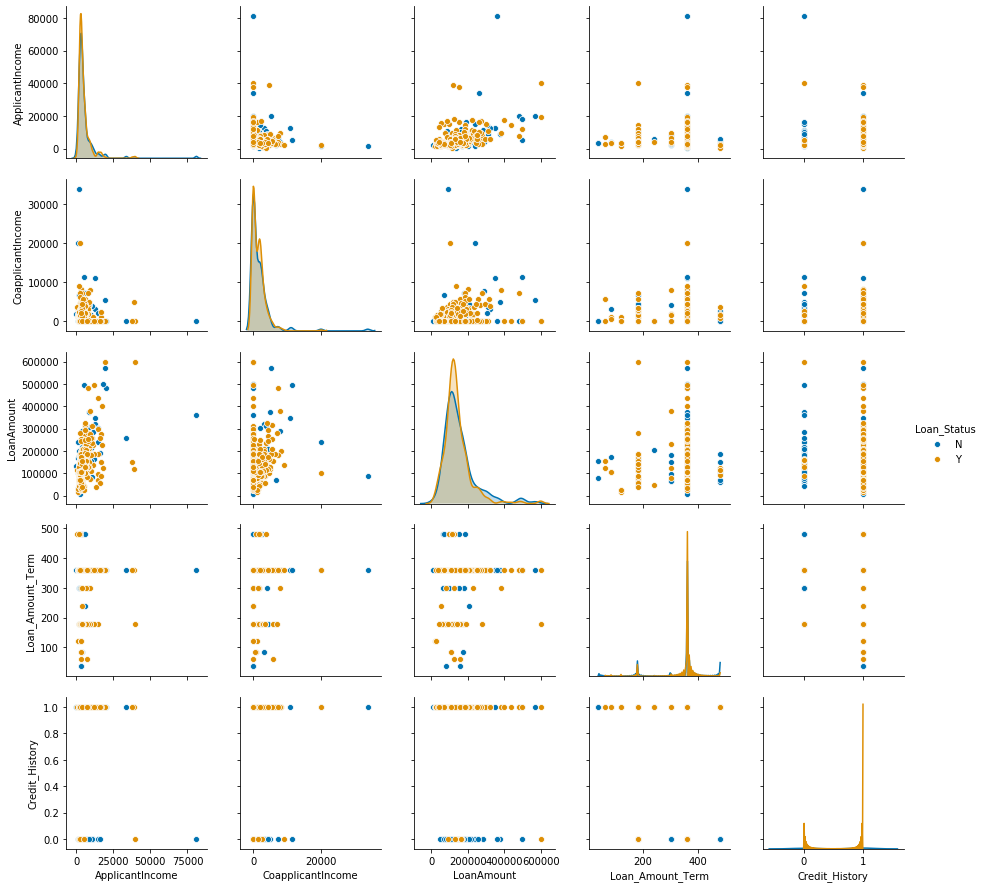

In [11]:
sns.pairplot(train, hue = 'Loan_Status', palette=current_palette)
plt.savefig('correlation_before.png', format='png')

## Categorizing numerically object columns by column name
- each column translated to binary value
- multi variables columns slpitted with dummy columns
- drop the duplications in the data

In [12]:
def categorize(df):
    df.Gender.replace({'Male': 1, 'Female': 0}, inplace = True)
    df.Married.replace({'Yes': 1, 'No': 0}, inplace = True)
    df.Education.replace({'Graduate': 1, 'Not Graduate': 0}, inplace = True)
    df.Self_Employed.replace({'Yes': 1, 'No': 0}, inplace = True)
    df = df.join(pd.get_dummies(df.Dependents, prefix='Dependents'))
    df.drop(columns= ['Dependents', 'Dependents_3+'], inplace=True)
    df = df.join(pd.get_dummies(df.Property_Area, prefix='Property_Area'))
    df.drop(columns= ['Property_Area', 'Property_Area_Rural'], inplace=True)
    return df

In [13]:
train = categorize(train)
test = categorize(test)

In [14]:
train.Loan_Status.replace({'Y': 1, 'N':0}, inplace=True)

## Model selection

### Adding and features:
- naive estimation of monthly loan return (LoanAmount/Loan_Amount_Term) normalized and with ln() getting the distribution to closer to normal distribution
- total income (ApplicantIncome + CoaplicantIncome) normlized and with ln() getting the distribution to closer to normal distribution

In [15]:
def add_feat(df):
    ln_monthly_return = np.log(df.LoanAmount/df.Loan_Amount_Term)
    df['ln_monthly_return'] = (ln_monthly_return - np.mean(ln_monthly_return))/(np.std(ln_monthly_return)/np.sqrt(len(ln_monthly_return)))
    
    ln_total_monthly_income = np.log(df.ApplicantIncome + df.CoapplicantIncome)
    df['ln_total_income'] = (ln_total_monthly_income - np.mean(ln_total_monthly_income))/(np.std(ln_total_monthly_income)/np.sqrt(len(ln_total_monthly_income)))
    
    ln_LoanAmount = np.log(1000*df.LoanAmount)
    df['ln_LoanAmount'] = (ln_LoanAmount - np.mean(ln_LoanAmount))/(np.std(ln_LoanAmount)/np.sqrt(len(ln_LoanAmount)))
    
    
    return df


In [16]:
train = add_feat(train)
test = add_feat(test)

- lets check the new features distributions

In [17]:

def norm_plt(df):
    f, axes = plt.subplots(3,2,figsize= (12,15),squeeze=False)

    ######total income########
    sns.distplot(df.ln_total_income
                 ,ax=axes[0,0]).set_title('ln(total_income) norm distribution')
    #axes[0,0].set_xlim(-100,100)
    axes[0,0].text(0.03, 0.85,
                   'skew: {0:0.2}\nkurtosis: {1:0.2f}'
                   .format(skew(df.ln_total_income),
                                          kurtosis(df.ln_total_income)),
                   horizontalalignment='left',
                   verticalalignment='bottom',
                   transform=axes[0,0].transAxes,
                   bbox={'facecolor': 'grey'})
    sns.distplot((df.ApplicantIncome+df.CoapplicantIncome),
                 ax=axes[0,1]).set_title('total_income distribution')
    axes[0,1].text(0.7, 0.85,
                   'skew: {0:0.2f}\nkurtosis: {1:0.2f}'
                   .format(skew(df.ApplicantIncome+df.CoapplicantIncome),
                           kurtosis(df.ApplicantIncome+df.CoapplicantIncome)),
                   horizontalalignment='left',
                   verticalalignment='bottom',
                   transform=axes[0,1].transAxes,
                   bbox={'facecolor': 'grey'})

    #######monthly return###########
    sns.distplot(df.ln_monthly_return,
                 ax=axes[1,0]).set_title('ln(monthly_return) norm distribution')
    #axes[1,0].set_xlim(-100,100)
    axes[1,0].text(0.03, 0.85,
                   'skew: {0:0.2}\nkurtosis: {1:0.2f}'
                   .format(skew(df.ln_monthly_return),
                           kurtosis(df.ln_monthly_return)),
                   horizontalalignment='left',
                   verticalalignment='bottom',
                   transform=axes[1,0].transAxes,
                   bbox={'facecolor': 'grey'})

    sns.distplot((1000*df.LoanAmount/df.Loan_Amount_Term),
                 ax=axes[1,1]).set_title('monthly_return distribution')
    axes[1,1].text(0.7, 0.85,
                   'skew: {0:0.2f}\nkurtosis: {1:0.2f}'
                   .format(skew(df.LoanAmount/df.Loan_Amount_Term),
                           kurtosis(df.LoanAmount/df.Loan_Amount_Term)),
                   horizontalalignment='left',
                   verticalalignment='bottom',
                   transform=axes[1,1].transAxes,
                   bbox={'facecolor': 'grey'})

    ######norm ln_LoanAmount########
    sns.distplot(df.ln_LoanAmount
                 ,ax=axes[2,0]).set_title('ln(LoanAmount) norm distribution')
    #axes[2,0].set_xlim(-100,100)
    axes[2,0].text(0.03, 0.85,
                   'skew: {0:0.2}\nkurtosis: {1:0.2f}'
                   .format(skew(df.ln_LoanAmount),
                                          kurtosis(df.ln_LoanAmount)),
                   horizontalalignment='left',
                   verticalalignment='bottom',
                   transform=axes[2,0].transAxes,
                   bbox={'facecolor': 'grey'})
    sns.distplot((df.LoanAmount),
                 ax=axes[2,1]).set_title('LoanAmount distribution')
    axes[2,1].text(0.7, 0.85,
                   'skew: {0:0.2f}\nkurtosis: {1:0.2f}'
                   .format(skew(df.LoanAmount),
                           kurtosis(df.LoanAmount)),
                   horizontalalignment='left',
                   verticalalignment='bottom',
                   transform=axes[2,1].transAxes,
                   bbox={'facecolor': 'grey'})
    
    
    ####### adding grid to the graph#########
    for i in range(3):
        for j in range(2):
            axes[i,j].grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')
    
    plt.savefig('normalizing_dists.png', format='png')

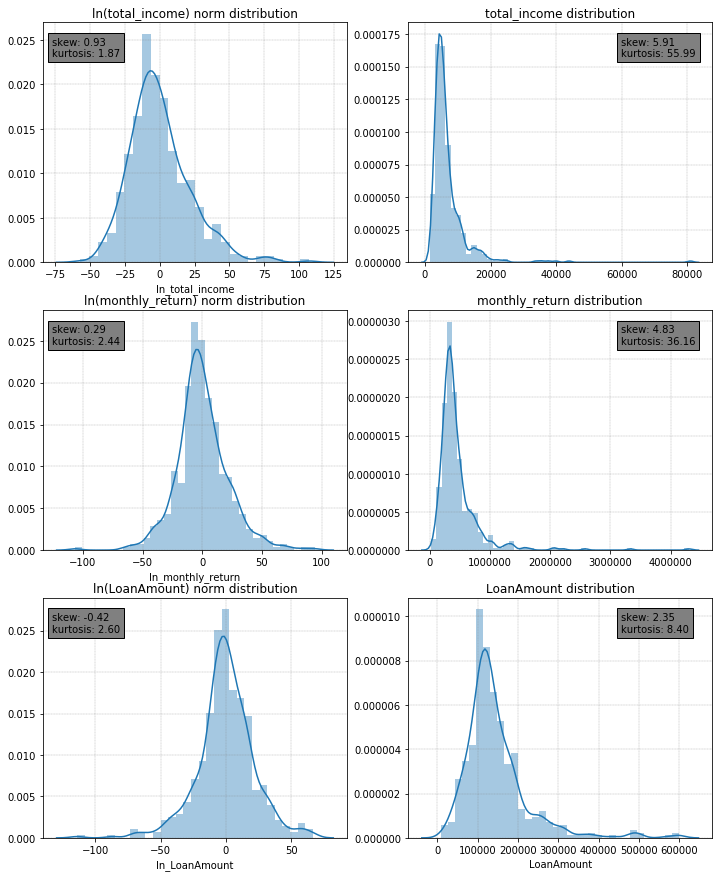

In [18]:
norm_plt(train)

- the skew and the kurtosis are much closer to 0, as expected from normalized normal distribution
- now lets drop the neglectable features, some of them found as not needed from previous run cycles, the others are dependeds of the new features created above

In [19]:
dropit=['LoanAmount', 
        'Loan_Amount_Term', 
        'ApplicantIncome',
        'CoapplicantIncome',
        'Married',
        'Dependents_0',
        'Dependents_1',
        'Dependents_2']
train.drop(columns=dropit, 
           inplace=True)
test.drop(columns=dropit, inplace=True)
train.shape
test.shape

(480, 10)

(289, 9)

- The following is sanity check to verify we didn't changed much the overall bias between the target values

1    0.691667
0    0.308333
Name: Loan_Status, dtype: float64

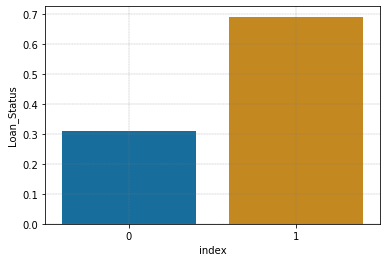

In [20]:
train['Loan_Status'].value_counts(normalize=True)
sns.barplot(data = train.Loan_Status.value_counts(normalize = True).reset_index(),
            x = 'index',
            y = 'Loan_Status',
            palette=current_palette)
plt.grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')
plt.savefig('Loan_Status_prop_after.png', format='png')

### Classifiers optimization

- In our case: binary classification, the "cross_val_score" function uses StratifiedKFold cross validation to reduce the bias effect in imbalanced data.

In [27]:

def cv_check(X,y, CV):
    models = [
        RandomForestClassifier(criterion='gini',
                               n_estimators=50,
                               max_depth=11,
                               max_features=6,
                               random_state=42,
                               class_weight='balanced_subsample',
                               n_jobs=4),
        SVC(C=1, kernel='rbf', gamma='auto',random_state=42,class_weight='balanced'),
        LogisticRegression(solver='lbfgs',
                           multi_class='ovr',
                           max_iter=500,
                           C=1,
                           random_state=42,
                           class_weight='balanced'),
        GaussianNB(),
        #LinearSVC(C=1, 
        #         max_iter=500,
        #          random_state=0),
        DummyClassifier(strategy='most_frequent',random_state=42)
    ]

    entries = []
    
    for model in models:
        model_name = model.__class__.__name__
        print ("Currently fitting: {}".format(model_name))
        accuracies = cross_val_score(model,
                                     X,
                                     y, 
                                     scoring='roc_auc', cv=CV, n_jobs=4)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'roc_auc'])
        
    return cv_df

In [28]:
def cv_bp(cv_df, title):
    plt.figure(figsize=(12,8))
    plt.grid(b=True, 
              which='both', 
              axis='both', 
              color='grey', 
              linestyle = '--', 
              linewidth = '0.3')    
    sns.boxplot(x='model_name', 
                y='roc_auc', 
                data=cv_df, 
                width = 0.5,
                palette=current_palette).set_title(title)
    sns.stripplot(x='model_name', 
                  y='roc_auc',
                  data=cv_df, 
                  size=5, jitter=True, 
                  edgecolor="gray", 
                  linewidth=1)
    plt.ylim(0.2,1)
    plt.savefig('{}.png'.format(title), format='png', pad_inches='tight')
    
    #plt.show()

In [29]:
"""
def df_splitter(df, colname):
    # split to 3 dataframes with approx. same size from the dataframe of Loan_Status = 'Y'
    # those dataframes are odd to each other
    t={}
    
    vc = df[colname].value_counts()
    
    n = int(np.floor(max(vc)/3.0))
    
   
    t['train0'] = df[df[colname]==vc.index[vc==max(vc)][0]].sample(n=n)
    print(t['train0'].shape)
    temp = df.drop(t['train0'].index, axis=0)
    
    t['train1'] = temp[temp[colname]==vc.index[vc==max(vc)][0]].sample(n=n)
    print(t['train1'].shape)

    temp.drop(labels=t['train1'].index, axis=0, inplace=True)
    
    t['train2'] = temp[temp[colname]==vc.index[vc==max(vc)][0]]
    print(t['train2'].shape)

    # each of the dataframe created is smaller than the dataframe of Loan_Status = 'N'
    # we will enlarge each by sampling equally from the other 2.
    # the dataframes won't be odd, but will common rows with each of the other 2, equally.
    
    Ns = min(df[colname].value_counts())
    
    keys = list(t.keys())
    tf={}
    temp={}
    for key in keys:
        keys = list(t.keys())
        keys.remove(key)       
        for i,k in enumerate(keys):
            if k not in temp.keys(): temp[k]=t[k] 
            if i==0:
                z = temp[k].sample(n=int(((Ns-t[key].shape[0])/2.0)),
                               random_state=42)
                tf[key] = pd.concat([t[key], z], copy=False)
    
            else:
                z = temp[k].sample(n=int((Ns-t[key].shape[0])/2.0),
                               random_state=42)
                tf[key] = pd.concat([tf[key], z], copy=False)
                
            temp[k] = temp[k].drop(labels = z.index, axis=0)
            print(k,temp[k].shape, key, tf[key].shape)

    for key in tf.keys():
        tf[key]=pd.concat([tf[key],df[df[colname]==vc.index[vc==min(vc)][0]]])

   # t['trainN'] = df[df[colname]==vc.index[vc==min(vc)][0]]

    
    return tf

"""
# the idea above improved the SVC, Logistic Regression and Naive Bayes classifier, 
# although the improvement wasn't sufficient to use in the last version of the classification.

"\ndef df_splitter(df, colname):\n    # split to 3 dataframes with approx. same size from the dataframe of Loan_Status = 'Y'\n    # those dataframes are odd to each other\n    t={}\n    \n    vc = df[colname].value_counts()\n    \n    n = int(np.floor(max(vc)/3.0))\n    \n   \n    t['train0'] = df[df[colname]==vc.index[vc==max(vc)][0]].sample(n=n)\n    print(t['train0'].shape)\n    temp = df.drop(t['train0'].index, axis=0)\n    \n    t['train1'] = temp[temp[colname]==vc.index[vc==max(vc)][0]].sample(n=n)\n    print(t['train1'].shape)\n\n    temp.drop(labels=t['train1'].index, axis=0, inplace=True)\n    \n    t['train2'] = temp[temp[colname]==vc.index[vc==max(vc)][0]]\n    print(t['train2'].shape)\n\n    # each of the dataframe created is smaller than the dataframe of Loan_Status = 'N'\n    # we will enlarge each by sampling equally from the other 2.\n    # the dataframes won't be odd, but will common rows with each of the other 2, equally.\n    \n    Ns = min(df[colname].value_counts()

In [30]:
"""
splitted = df_splitter(train, 'Loan_Status')

# check my code:
print('common indexes between train2 and train1: {}'
      .format(len(set(splitted['train2'].index)&set(splitted['train1'].index))))
print('common indexes between train0 and train1: {}'
      .format(len(set(splitted['train0'].index)&set(splitted['train1'].index))))
print('common indexes between train2 and train0: {}'
      .format(len(set(splitted['train2'].index)&set(splitted['train0'].index))))

splitted['train0'].shape
splitted['train1'].shape
splitted['train2'].shape
"""

"\nsplitted = df_splitter(train, 'Loan_Status')\n\n# check my code:\nprint('common indexes between train2 and train1: {}'\n      .format(len(set(splitted['train2'].index)&set(splitted['train1'].index))))\nprint('common indexes between train0 and train1: {}'\n      .format(len(set(splitted['train0'].index)&set(splitted['train1'].index))))\nprint('common indexes between train2 and train0: {}'\n      .format(len(set(splitted['train2'].index)&set(splitted['train0'].index))))\n\nsplitted['train0'].shape\nsplitted['train1'].shape\nsplitted['train2'].shape\n"

In [31]:
unif = train
"""pd.concat([splitted['train0'],splitted['train1'],splitted['train2']], ignore_index=True)"""

"pd.concat([splitted['train0'],splitted['train1'],splitted['train2']], ignore_index=True)"

Currently fitting: RandomForestClassifier
Currently fitting: SVC
Currently fitting: LogisticRegression
Currently fitting: GaussianNB
Currently fitting: DummyClassifier


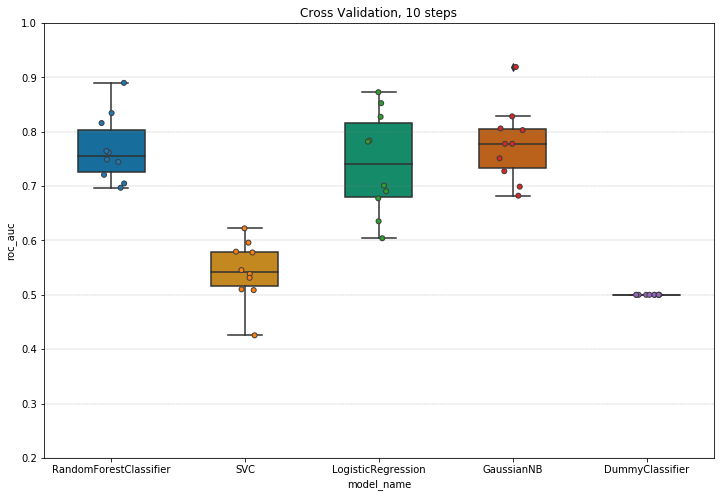

In [32]:
cv_bp(cv_check(unif.drop(['Loan_Status'],axis=1),
               unif.Loan_Status,10), 
      'Cross Validation, 10 steps')

- using grid search cross validation we scanned to find the optimal values for each model variables
- the values chosen after several runs to get the optimum variables within the optimal range for the roc_auc as closer we can get to 1

In [33]:
# the following is a grid search function to evaluate each model in a cosen parameters and ranges
def model_score(train, model, grid_values, scorers_list):
    X_train = train.drop(columns=['Loan_Status'])
    y_train = train['Loan_Status']
    
    clf_dict = {}
    
    for i, scorer in enumerate(scorers_list):
        clf_eval = GridSearchCV(model, param_grid=grid_values, scoring=scorer, cv=5, iid=False, n_jobs=-1)
        clf_eval.fit(X_train,y_train)
        print('Grid best parameters for {0}: {1} scoring: {2}'
              .format(scorer, clf_eval.best_params_, round(clf_eval.best_score_,3)))
        clf_dict[scorer] = clf_eval
    return clf_dict

### RandomForest

In [34]:
grid_values = {'max_features': [4, 5, 6, 7],
              'max_depth': [3, 7, 11, 13]}
scorers_list = ['accuracy','roc_auc','precision','recall', 'f1']

rf_cv = model_score(unif,
            RandomForestClassifier(random_state=42, 
                                   n_jobs=4, 
                                   class_weight='balanced_subsample', 
                                   n_estimators=50), 
            grid_values, 
            scorers_list)

temp_df1 = pd.DataFrame()
for i in scorers_list:
      temp_df1[i]=rf_cv[i].cv_results_['mean_test_score'][rf_cv[i].cv_results_['param_max_features']==4]
temp_df1['max_depth'] = rf_cv['roc_auc'].cv_results_['param_max_depth'][rf_cv['roc_auc'].cv_results_['param_max_features']==4]
temp_df1.set_index('max_depth', inplace=True)
print('4:\n')
temp_df1

temp_df2 = pd.DataFrame()
for i in scorers_list:
      temp_df2[i]=rf_cv[i].cv_results_['mean_test_score'][rf_cv[i].cv_results_['param_max_features']==6]
temp_df2['max_depth'] = rf_cv['roc_auc'].cv_results_['param_max_depth'][rf_cv['roc_auc'].cv_results_['param_max_features']==6]
temp_df2.set_index('max_depth', inplace=True)
print('6:\n')
temp_df2

Grid best parameters for accuracy: {'max_depth': 7, 'max_features': 4} scoring: 0.806
Grid best parameters for roc_auc: {'max_depth': 11, 'max_features': 7} scoring: 0.764
Grid best parameters for precision: {'max_depth': 13, 'max_features': 6} scoring: 0.816
Grid best parameters for recall: {'max_depth': 3, 'max_features': 7} scoring: 0.949
Grid best parameters for f1: {'max_depth': 3, 'max_features': 6} scoring: 0.871
4:



accuracy   roc_auc  precision    recall        f1
max_depth                                                   
3          0.800048  0.761711   0.802100  0.945635  0.867374
7          0.806429  0.747636   0.811852  0.939711  0.870719
11         0.796011  0.751675   0.812624  0.918634  0.861878
13         0.802196  0.757177   0.815836  0.924604  0.866319

6:



accuracy   roc_auc  precision    recall        f1
max_depth                                                   
3          0.806299  0.750013   0.806620  0.948621  0.871263
7          0.797986  0.747833   0.810483  0.927544  0.863807
11         0.791779  0.762396   0.814869  0.906513  0.857751
13         0.798095  0.754848   0.816493  0.915604  0.862731

### LogisticRegression

In [35]:
grid_values = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}
scorers_list = ['accuracy','roc_auc','precision','recall', 'f1']


lr_cv = model_score(unif,
                    LogisticRegression(solver='liblinear',random_state=42, max_iter=500,
                                      class_weight='balanced'),
                    grid_values,
                    scorers_list)


temp_df1 = pd.DataFrame()
for i in scorers_list:
      temp_df1[i]=lr_cv[i].cv_results_['mean_test_score'][lr_cv[i].cv_results_['param_penalty']=='l1']
temp_df1['C'] = lr_cv['roc_auc'].cv_results_['param_C'][lr_cv['roc_auc'].cv_results_['param_penalty']=='l1']
temp_df1.set_index('C', inplace=True)
print('l1:\n')
temp_df1

temp_df2 = pd.DataFrame()
for i in scorers_list:
      temp_df2[i]=lr_cv[i].cv_results_['mean_test_score'][lr_cv[i].cv_results_['param_penalty']=='l2']
temp_df2['C'] = lr_cv['roc_auc'].cv_results_['param_C'][lr_cv['roc_auc'].cv_results_['param_penalty']=='l2']
temp_df2.set_index('C', inplace=True)
print('l2:\n')
temp_df2

Grid best parameters for accuracy: {'C': 0.1, 'penalty': 'l1'} scoring: 0.788
Grid best parameters for roc_auc: {'C': 10, 'penalty': 'l1'} scoring: 0.749
Grid best parameters for precision: {'C': 10, 'penalty': 'l2'} scoring: 0.81
Grid best parameters for recall: {'C': 0.1, 'penalty': 'l1'} scoring: 0.943
Grid best parameters for f1: {'C': 0.1, 'penalty': 'l1'} scoring: 0.859
l1:



accuracy   roc_auc  precision    recall        f1
C                                                        
0.01    0.510093  0.516256   0.690734  0.523564  0.593629
0.10    0.787569  0.706558   0.791476  0.942650  0.859448
1.00    0.764476  0.749043   0.801864  0.885165  0.837551
10.00   0.756185  0.749079   0.809419  0.852148  0.827893
100.00  0.756185  0.748577   0.809419  0.852148  0.827893

l2:



accuracy   roc_auc  precision    recall        f1
C                                                        
0.01    0.745723  0.685509   0.791474  0.855224  0.819647
0.10    0.766798  0.730650   0.792421  0.900543  0.841286
1.00    0.760352  0.744763   0.798492  0.882225  0.835013
10.00   0.758247  0.748590   0.809971  0.855133  0.829481
100.00  0.756185  0.748378   0.809419  0.852148  0.827893

### SVC

In [36]:
grid_values = {'C': [1, 10],
              'gamma': [0.5, 0.7, 0.9, 0.95]}
scorers_list = ['accuracy','roc_auc','precision','recall', 'f1']


svc_cv = model_score(unif,
                    SVC(random_state=42, class_weight='balanced',kernel='rbf'),
                    grid_values,
                    scorers_list)


temp_df1 = pd.DataFrame()
for i in scorers_list:
      temp_df1[i]=svc_cv[i].cv_results_['mean_test_score'][svc_cv[i].cv_results_['param_C']==1]
temp_df1['gamma'] = svc_cv['roc_auc'].cv_results_['param_gamma'][svc_cv['roc_auc'].cv_results_['param_C']==1]
temp_df1.set_index('gamma', inplace=True)
print('C=1:\n')
temp_df1

temp_df2 = pd.DataFrame()
for i in scorers_list:
      temp_df2[i]=svc_cv[i].cv_results_['mean_test_score'][svc_cv[i].cv_results_['param_C']==10]
temp_df2['gamma'] = svc_cv['roc_auc'].cv_results_['param_gamma'][svc_cv['roc_auc'].cv_results_['param_C']==10]
temp_df2.set_index('gamma', inplace=True)
print('C=10:\n')
temp_df2

Grid best parameters for accuracy: {'C': 1, 'gamma': 0.9} scoring: 0.681
Grid best parameters for roc_auc: {'C': 10, 'gamma': 0.95} scoring: 0.535
Grid best parameters for precision: {'C': 1, 'gamma': 0.9} scoring: 0.69
Grid best parameters for recall: {'C': 1, 'gamma': 0.9} scoring: 0.979
Grid best parameters for f1: {'C': 1, 'gamma': 0.9} scoring: 0.809
C=1:



accuracy   roc_auc  precision    recall        f1
gamma                                                   
0.50   0.668961  0.511355   0.688231  0.951877  0.798756
0.70   0.679291  0.515019   0.689307  0.975938  0.807906
0.90   0.681353  0.530905   0.689979  0.978924  0.809394
0.95   0.681353  0.530922   0.689979  0.978924  0.809394

C=10:



accuracy   roc_auc  precision    recall        f1
gamma                                                   
0.50   0.666856  0.522581   0.686688  0.951877  0.797706
0.70   0.675103  0.526600   0.687949  0.969878  0.804880
0.90   0.679291  0.531901   0.689307  0.975938  0.807906
0.95   0.679291  0.534684   0.689307  0.975938  0.807906

### The following are the main functions to run each model evaluation in the chosen best values

In [37]:
def mod_eval(predictions, predprob, y_test, title):
    # prints confusion matrix heatmap    
    cm = confusion_matrix(train.Loan_Status[y_test.index], predictions)
    sns.heatmap(cm, annot=True, fmt='.3g', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes']).set_title(title)
    plt.xlabel('Real')
    plt.ylabel('Predict')
    plt.savefig('{}_confmat.png'.format(title), format='png')
    
    #output classification report to prompt and to csv file
    cr = classification_report(train.Loan_Status[y_test.index], predictions, output_dict=True)
    df = pd.DataFrame(cr).transpose()
    df.to_csv('class_rep_{}.csv'.format(title))
    print(classification_report(train.Loan_Status[y_test.index], predictions))
    
    #plot side by side
    f, axes = plt.subplots(1,2,figsize= (20,6),squeeze=False)
    
    #roc curve and auc data in the title
    fpr, tpr, _ = roc_curve(train.Loan_Status[y_test.index], predprob[:,1])
    roc_auc = auc(fpr,tpr)
    axes[0,0].plot(fpr, tpr, lw=3)
    axes[0,0].set_title('{} ROC curve (area = {:0.2f})'.format(title, roc_auc))
    axes[0,0].set(xlabel='False Positive Rate',ylabel='True Positive Rate')
    axes[0,0].grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')
    #plot precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, predprob[:,1])
    best_index = np.argmin(np.abs(precision-recall))   # set the best index to be the minimum delta between precision and recall
    axes[0,1].plot(precision,recall)
    axes[0,1].set_title('{} Precision-Recall Curve'.format(title))
    axes[0,1].set(xlabel='Precision', ylabel='Recall', xlim=(0.4,1.05))
    axes[0,1].plot(precision[best_index],recall[best_index],'o',color='r')
    axes[0,1].grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')
    plt.savefig('{}.png'.format(title), format='png')
    return

In [38]:
def model_training(classifier,train):
    clf = classifier
    t=train.drop(columns=['Loan_Status'])
    X_train, X_test, y_train, y_tests = train_test_split(t,
                                                         train['Loan_Status'],
                                                         test_size=ts,
                                                         stratify=train['Loan_Status'])
    clf.fit(X_train, y_train)
    return clf

### Chosen values per model

In [39]:
#RandomForest
max_depth=11
max_features=6

In [40]:
#LogisticRegression
lr_C=0.1
penalty='l1'

In [41]:
#SVC
svc_C=1
gamma=0.9

In [42]:
#Test Size
ts = 0.333

## RandomForest

              precision    recall  f1-score   support

           0       0.98      0.82      0.89        49
           1       0.92      0.99      0.96       111

    accuracy                           0.94       160
   macro avg       0.95      0.90      0.92       160
weighted avg       0.94      0.94      0.94       160



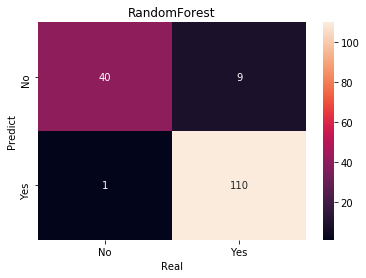

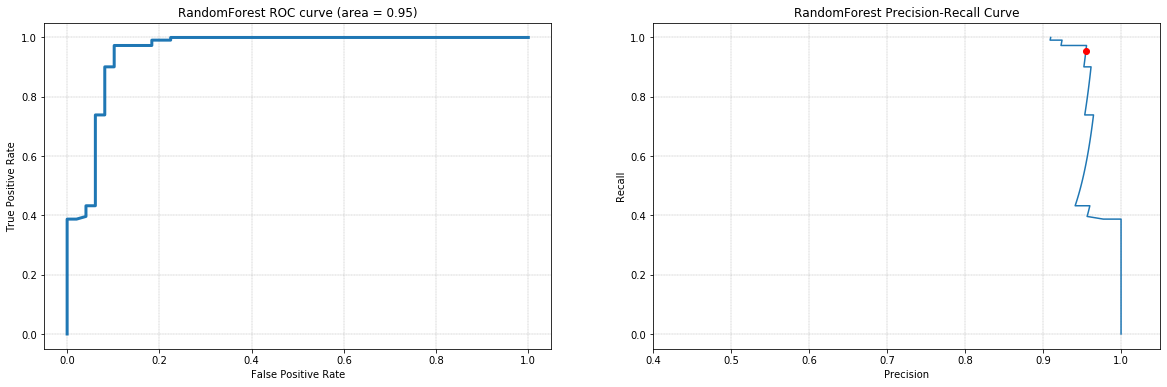

fi
Credit_History           0.272628
ln_total_income          0.226297
ln_monthly_return        0.212182
ln_LoanAmount            0.181648
Gender                   0.025705
Property_Area_Semiurban  0.024018
Property_Area_Urban      0.023311
Self_Employed            0.018806
Education                0.015406

<Figure size 864x360 with 0 Axes>

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

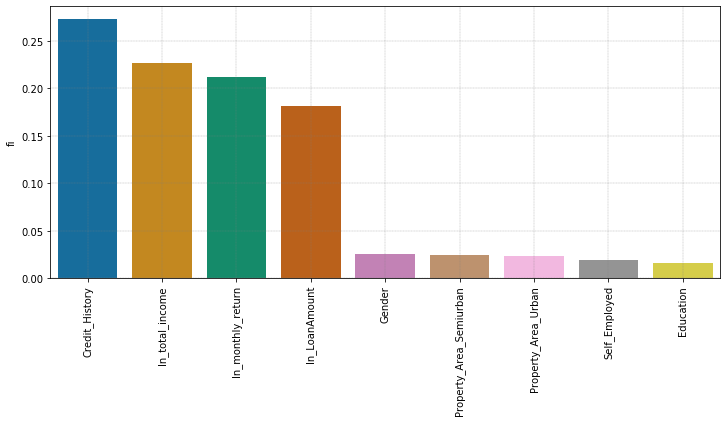

In [43]:
rf = model_training(RandomForestClassifier(random_state=42, 
                                           n_jobs=4, 
                                           n_estimators=50, 
                                           max_depth=max_depth,
                                           max_features=max_features),unif)

t=train.drop(columns=['Loan_Status'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                     train['Loan_Status'],
                                                     test_size=ts,
                                                     stratify=train['Loan_Status'])

mod_eval(rf.predict(X_test), rf.predict_proba(X_test), y_test, 'RandomForest')
plt.show()

fi_df = pd.DataFrame({'fi': rf.feature_importances_},index=t.columns).sort_values(by='fi', ascending=False)
fi_df

plt.figure(figsize=(12,5))
plt.xticks(rotation='vertical')
sns.barplot(x=fi_df.index, y=fi_df['fi'], palette=current_palette)
plt.savefig('rf_feat_impor.png', format='png', bbox_inches='tight')
plt.grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')
plt.show()

## LogisticRegression

              precision    recall  f1-score   support

           0       0.82      0.57      0.67        49
           1       0.83      0.95      0.89       111

    accuracy                           0.83       160
   macro avg       0.83      0.76      0.78       160
weighted avg       0.83      0.83      0.82       160



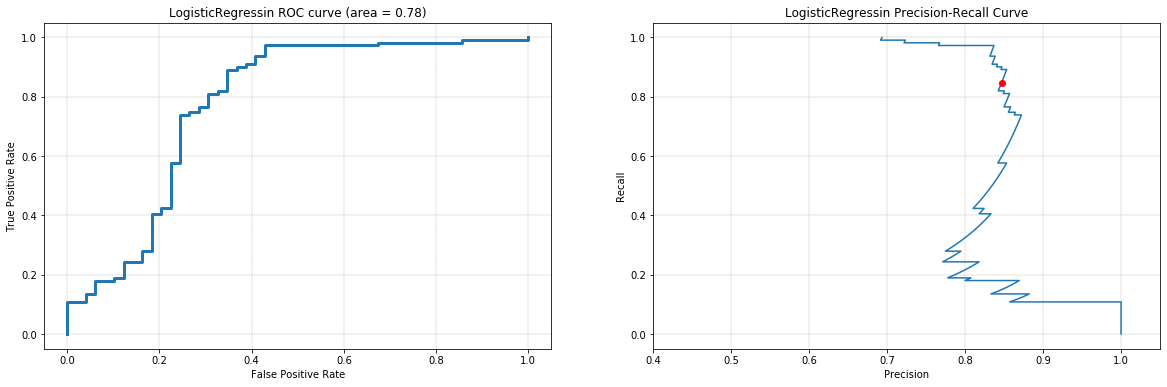

In [44]:
lr = model_training(LogisticRegression(C=lr_C, 
                                       penalty=penalty,
                                       solver='liblinear',
                                       max_iter=1000),unif)

t=train.drop(columns=['Loan_Status'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                    train['Loan_Status'],
                                                    test_size=ts,
                                                    random_state = 42, stratify=train['Loan_Status'])

t = 0.71
predprob = lr.predict_proba(X_test)

pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]

#pred_y = lr.predict(X_test)
mod_eval(pred_y, lr.predict_proba(X_test), y_test, 'LogisticRegressin') 
plt.show()

## NaiveBayes

In [45]:
gnb = model_training(GaussianNB(),unif)

t=train.drop(columns=['Loan_Status'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                    train['Loan_Status'],
                                                    test_size=ts,
                                                    random_state = 42, stratify=train['Loan_Status'])


t = 0.75
predprob = gnb.predict_proba(X_test)

pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]
#pred_y = gnb.predict(X_test)
mod_eval(pred_y, gnb.predict_proba(X_test), y_test, 'GaussianNB')
plt.show()

              precision    recall  f1-score   support

           0       0.78      0.57      0.66        49
           1       0.83      0.93      0.88       111

    accuracy                           0.82       160
   macro avg       0.80      0.75      0.77       160
weighted avg       0.81      0.82      0.81       160



## SVC

In [46]:
svc = model_training(SVC(kernel='linear',
                         C=1, 
                         gamma='auto',
                         class_weight='balanced',
                         probability=True),unif)


t=train.drop(columns=['Loan_Status'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                    train['Loan_Status'],
                                                    test_size=ts,
                                                    random_state = 42, stratify=train['Loan_Status'])

t=0.75
print('t={}'.format(t))
predprob = svc.predict_proba(X_test)

pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]
#pred_y = svc.predict(X_test)

mod_eval(pred_y, svc.predict_proba(X_test), y_test, 'SVC')
plt.show()

t=0.75
              precision    recall  f1-score   support

           0       0.48      0.69      0.57        49
           1       0.83      0.67      0.74       111

    accuracy                           0.68       160
   macro avg       0.66      0.68      0.65       160
weighted avg       0.72      0.68      0.69       160



## Dummy

              precision    recall  f1-score   support

           0       0.37      0.37      0.37        49
           1       0.72      0.72      0.72       111

    accuracy                           0.61       160
   macro avg       0.54      0.54      0.54       160
weighted avg       0.61      0.61      0.61       160



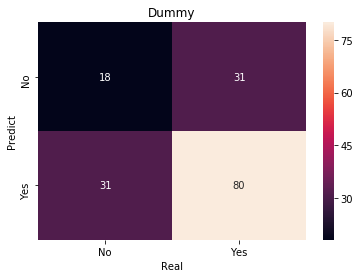

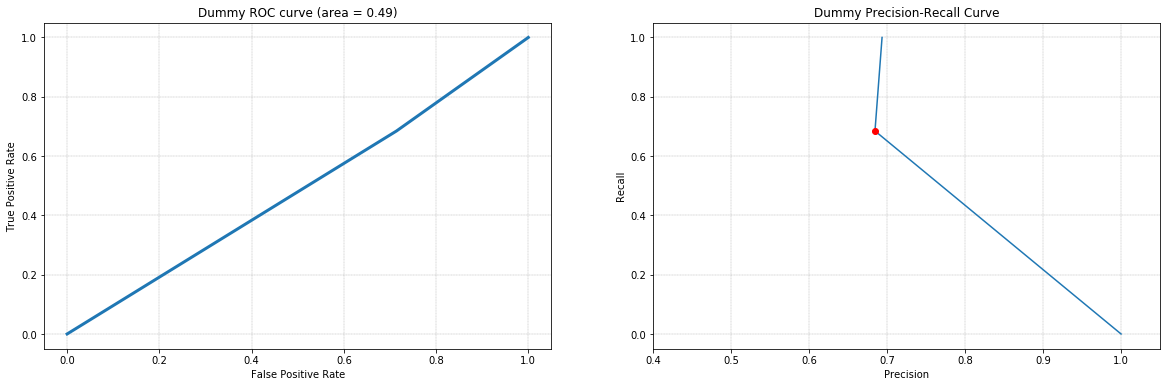

In [47]:
dummy = model_training(DummyClassifier(strategy='stratified'),unif)

t=train.drop(columns=['Loan_Status'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                    train['Loan_Status'],
                                                    test_size=ts,
                                                    random_state = 42, stratify=train['Loan_Status'])

t = 0.5
predprob = dummy.predict_proba(X_test)

pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]
#pred_y = dummy.predict(X_test)

mod_eval(pred_y, dummy.predict_proba(X_test), y_test, 'Dummy')
plt.show()

### Save best model to a file for API

In [48]:
joblib.dump(rf, 'RandomForest_Loan_Model.pkl')

['RandomForest_Loan_Model.pkl']